<p><font size="6"><b> CASE - Bike count data</b></font></p>


> *DS Data manipulation, analysis and visualisation in Python*  
> *December, 2019*

> *© 2016, Joris Van den Bossche and Stijn Van Hoey  (<mailto:jorisvandenbossche@gmail.com>, <mailto:stijnvanhoey@gmail.com>). Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

<img src="https://nbocdn.akamaized.net/Assets/Images_Upload/2016/11/24/GEFV45415.jpg?maxheight=460&maxwidth=638">

In this case study, we will make use of the freely available bike count data of the city of Ghent. At the Coupure Links, next to the Faculty of Bioscience Engineering, a counter keeps track of the number of passing cyclists in both directions.  

Those data are available on the open data portal of the city: https://data.stad.gent/data/236

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Reading and processing the data

### Read csv data from URL

The data are avaible in CSV, JSON and XML format. We will make use of the CSV data. The link to download the data can be found on the webpage. For the first dataset, this is:

    link = "https://datatank.stad.gent/4/mobiliteit/fietstellingencoupure.csv"
    
A limit defines the size of the requested data set, by adding a limit parameter `limit` to the URL :

    link = "https://datatank.stad.gent/4/mobiliteit/fietstellingencoupure.csv?limit=100000"

Those datasets contain the historical data of the bike counters, and consist of the following columns:

- The first column `datum` is the date, in `dd/mm/yy` format
- The second column `tijd` is the time of the day, in `hh:mm` format
- The third and fourth column `ri Centrum` and `ri Mariakerke` are the counts at that point in time (counts between this timestamp and the previous)

In [52]:
limit = 200000
link = "https://datatank.stad.gent/4/mobiliteit/fietstellingencoupure.csv?limit={}".format(limit)

<div class="alert alert-success">
 <b>EXERCISE</b>:
 <ul>
  <li>Read the csv file from the url into a DataFrame `df`, the delimiter of the data is `;`</li>
  <li>Inspect the first and last 5 rows, and check the number of observations</li>
  <li>Inspect the data types of the different columns</li>

</ul> 

</div>

In [53]:
df = pd.read_csv(link, sep=';')

In [54]:
df.head()

,datum,tijd,ri Centrum,ri Mariakerke
0,14/07/2011,17:44,21,46
1,14/07/2011,17:59,17,60
2,14/07/2011,18:14,13,48
3,14/07/2011,18:29,22,48
4,14/07/2011,18:44,15,51


In [55]:
df.tail()

,datum,tijd,ri Centrum,ri Mariakerke
191442,18/01/2017,22:54,16,32
191443,18/01/2017,23:09,8,22
191444,18/01/2017,23:24,10,29
191445,18/01/2017,23:39,11,31
191446,18/01/2017,23:54,12,19


In [56]:
len(df)

191447

In [57]:
df.dtypes

datum            object
tijd             object
ri Centrum        int64
ri Mariakerke     int64
dtype: object

<div class="alert alert-warning">

 <b>Remark</b>: If the download is very slow, consider to reset the limit variable to a lower value as most execises will just work with the first 100000 records as well.

</div>

### Data processing

As explained above, the first and second column (respectively `datum` and `tijd`) indicate the date and hour of the day. To obtain a time series, we have to combine those two columns into one series of actual datetime values. 

<div class="alert alert-success">

 <b>EXERCISE</b>: Preprocess the data

 <ul>
  <li>Combine the 'datum' and 'tijd' columns into one Series of string datetime values (Hint: concatenating strings can be done with the addition operation)</li>
  <li>Parse the string datetime values (Hint: specifying the format will make this a lot faster)</li>
  <li>Set the resulting dates as the index</li>
  <li>Remove the original 'tijd' and 'tijd' columns (Hint: check the <code>drop</code> method)</li>
  <li>Rename the 'ri Centrum', 'ri Mariakerke' to 'direction_centre', 'direction_mariakerke' (Hint: check the <code>rename</code> function)</li>
</ul> 

</div>

In [58]:
combined = df['datum'] + ' ' + df['tijd']
combined.head()

0    14/07/2011 17:44
1    14/07/2011 17:59
2    14/07/2011 18:14
3    14/07/2011 18:29
4    14/07/2011 18:44
dtype: object

In [59]:
df.index = pd.to_datetime(combined, format="%d/%m/%Y %H:%M")

In [60]:
df = df.drop(columns=['datum', 'tijd'])

In [61]:
df = df.rename(columns={'ri Centrum': 'direction_centre', 'ri Mariakerke':'direction_mariakerke'})

In [62]:
df.head()

,direction_centre,direction_mariakerke
2011-07-14 17:44:00,21,46
2011-07-14 17:59:00,17,60
2011-07-14 18:14:00,13,48
2011-07-14 18:29:00,22,48
2011-07-14 18:44:00,15,51


Having the data available with an interpreted datetime, provides us the possibility of having time aware plotting:

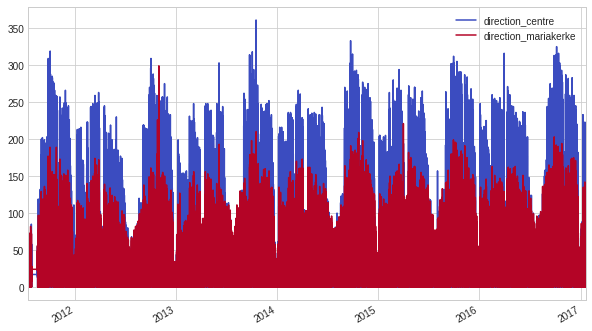

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(colormap='coolwarm', ax=ax)

<div class="alert alert-warning">

 <b>Remark</b>: Interpretation of the dates with and without predefined date format.

</div>

When we just want to interpret the dates, without specifying how the dates are formatted, Pandas makes an attempt as good as possible:

In [64]:
%timeit -n 1 -r 1 pd.to_datetime(combined, dayfirst=True)

17.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


However, when we already know the format of the dates (and if this is consistent throughout the full dataset), we can use this information to interpret the dates:

In [65]:
%timeit pd.to_datetime(combined, format="%d/%m/%Y %H:%M")

508 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<div class="alert alert-info">

 <b>Remember</b>: Whenever possible, specify the date format to interpret the dates to datetime values!

</div>

### Write the data set cleaning as a function

In order to make it easier to reuse the code for the preprocessing we have now implemented, let's convert the code to a Python function

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Write a function <code>process_bike_count_data(df)</code> that performs the processing steps as done above for an input DataFrame and return the updated DataFrame</li>
</ul> 

</div>

In [66]:
def process_bike_count_data(df):
    """
    Process the provided dataframe: parse datetimes and rename columns.
    
    """
    df.index = pd.to_datetime(df['datum'] + ' ' + df['tijd'], format="%d/%m/%Y %H:%M")
    df = df.drop(columns=['datum', 'tijd'])
    df = df.rename(columns={'ri Centrum': 'direction_centre', 'ri Mariakerke':'direction_mariakerke'})
    return df

In [67]:
df_raw = pd.read_csv(link, sep=';')
df_preprocessed = process_bike_count_data(df_raw)

### Store our collected dataset as an interim data product

As we finished our data-collection step, we want to save this result as a interim data output of our small investigation. As such, we do not have to re-download all the files each time something went wrong, but can restart from our interim step.

In [68]:
df_preprocessed.to_csv("bike_count_interim.csv")

## Data exploration and analysis

We now have a cleaned-up dataset of the bike counts at Coupure Links. Next, we want to get an impression of the characteristics and properties of the data

### Load the interim data

Reading the file in from the interim file (when you want to rerun the whole analysis on the updated online data, you would comment out this cell...)

In [69]:
df = pd.read_csv("bike_count_interim.csv", index_col=0, parse_dates=True)

### Count interval verification

The number of bikers are counted for intervals of approximately 15 minutes. But let's check if this is indeed the case.  
For this, we want to calculate the difference between each of the consecutive values of the index. We can use the `Series.diff()` method:

In [70]:
pd.Series(df.index).diff()

0             NaT
1        00:15:00
2        00:15:00
3        00:15:00
4        00:15:00
           ...   
191442   00:15:00
191443   00:15:00
191444   00:15:00
191445   00:15:00
191446   00:15:00
Length: 191447, dtype: timedelta64[ns]

Again, the count of the possible intervals is of interest:

In [71]:
pd.Series(df.index).diff().value_counts()

0 days 00:15:00      191356
0 days 00:16:00           9
0 days 00:09:00           6
-1 days +23:15:00         6
0 days 00:13:00           6
0 days 00:04:00           5
0 days 01:15:00           5
0 days 00:06:00           4
0 days 00:12:00           4
0 days 00:11:00           4
0 days 00:03:00           4
0 days 00:00:00           4
0 days 00:02:00           4
0 days 00:08:00           4
0 days 00:10:00           3
0 days 00:01:00           3
0 days 00:38:00           3
0 days 00:37:00           3
0 days 00:14:00           2
0 days 00:05:00           2
0 days 01:11:00           1
0 days 00:26:00           1
0 days 00:20:00           1
0 days 00:29:00           1
0 days 01:24:00           1
0 days 00:30:00           1
0 days 06:49:00           1
0 days 00:07:00           1
20 days 21:29:00          1
dtype: int64

There are a few records that is not exactly 15min. But given it are only a few ones, we will ignore this for the current case study and just keep them as such for this explorative study.  

Bonus question: do you know where the values of `-1 days +23:15:01` and `01:15:00` are coming from?

In [72]:
df.describe()

,direction_centre,direction_mariakerke
count,191447.000000,191447.000000
mean,25.545237,25.338585
std,31.625619,26.903810
min,0.000000,0.000000
25%,5.000000,7.000000
50%,17.000000,17.000000
75%,34.000000,34.000000
max,361.000000,299.000000


### Quiet periods

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Create a new Series, <code>df_both</code> which contains the sum of the counts of both directions</li>
</ul> 

<br>

_Tip:_ check the purpose of the `axis` argument of the `sum` function

</div>

In [73]:
df_both = df.sum(axis=1)

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Using the <code>df_both</code> from the previous exercise, create a new Series <code>df_quiet</code> which contains only those intervals for which less than 5 cyclists passed in both directions combined</li>
</ul> 

</div>

In [74]:
df_quiet = df_both[df_both < 5]

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Using the original data, select only the intervals for which less than 3 cyclists passed in one or the other direction. Hence, less than 3 cyclists towards the centre or less than 3 cyclists towards Mariakerke.</li>
</ul> 

</div>

In [75]:
df[(df['direction_centre'] < 3) | (df['direction_mariakerke'] < 3)]

,direction_centre,direction_mariakerke
2011-07-14 23:59:00,1,13
2011-07-15 00:14:00,2,3
2011-07-15 00:44:00,2,6
2011-07-15 00:59:00,0,4
2011-07-15 01:29:00,1,10
...,...,...
2017-01-18 06:09:00,2,2
2017-01-18 06:24:00,7,1
2017-01-18 06:39:00,2,2
2017-01-18 06:54:00,8,2


### Count statistics

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>What is the average number of bikers passing each 15 min?</li>
</ul> 

</div>

In [76]:
df.mean()

direction_centre        25.545237
direction_mariakerke    25.338585
dtype: float64

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>What is the average number of bikers passing each hour?</li>
</ul> 

_Tip:_ you can use `resample` to first calculate the number of bikers passing each hour.

</div>

In [77]:
df.resample('H').sum().mean()

direction_centre        101.113548
direction_mariakerke    100.295573
dtype: float64

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>What are the 10 highest peak values observed during any of the intervals for the direction towards the centre of Ghent?</li>
</ul> 

</div>

In [78]:
df['direction_centre'].nlargest(10)
# alternative:
# df['direction_centre'].sort_values(ascending=False).head(10)

2013-10-16 21:38:00    361
2014-09-23 08:12:00    333
2016-10-06 09:16:00    325
2011-10-04 08:27:00    319
2013-10-03 08:49:00    318
2016-03-31 00:45:00    316
2016-10-13 09:16:00    316
2014-09-30 08:05:00    315
2013-09-23 08:34:00    314
2016-10-04 09:01:00    314
Name: direction_centre, dtype: int64

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>What is the maximum number of cyclist that passed on a single day calculated on both directions combined?</li>
</ul> 

</div>

In [79]:
df_both = df.sum(axis=1)

In [80]:
df_daily = df_both.resample('D').sum()

In [81]:
df_daily.max()

10770

In [82]:
df_daily.nlargest(10)

2016-09-29    10770
2016-09-28    10640
2016-09-27    10394
2014-11-05    10321
2016-10-04    10295
2012-10-30    10213
2016-10-05    10179
2016-10-06    10157
2013-06-05    10041
2016-10-13     9996
dtype: int64

2013-06-05 was the first time more than 10,000 bikers passed on one day. Apparanlty, this was not just by coincidence... http://www.nieuwsblad.be/cnt/dmf20130605_022

### Trends as function of time

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>How does the long-term trend look like? Calculate monthly sums and plot the result.</li>
</ul> 

</div>

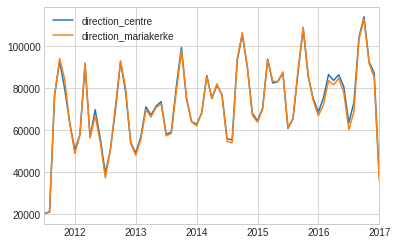

In [83]:
df_monthly = df.resample('M').sum()
df_monthly.plot()

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Let's have a look at some short term patterns. For the data of the first 3 weeks of January 2014, calculate the hourly counts and visualize them.</li>
</ul> 

</div>

In [84]:
df_hourly = df.resample('H').sum()

In [85]:
df_hourly.head()

,direction_centre,direction_mariakerke
2011-07-14 17:00:00,38,106
2011-07-14 18:00:00,66,177
2011-07-14 19:00:00,62,92
2011-07-14 20:00:00,45,40
2011-07-14 21:00:00,28,30


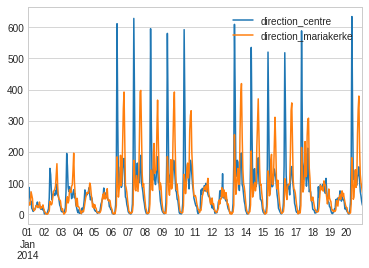

In [86]:
df_hourly['2014-01-01':'2014-01-20'].plot()

**New Year's Eve 2013-2014**

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Select a subset of the data set from 2013-12-31 12:00:00 untill 2014-01-01 12:00:00, store as variable <code>newyear</code> and plot this subset</li>
  <li>Use a <code>rolling</code> function (check documentation of the function!) to smooth the data of this period and make a plot of the smoothed version</li>
</ul> 

</div>

In [87]:
newyear = df["2013-12-31 12:00:00": "2014-01-01 12:00:00"]

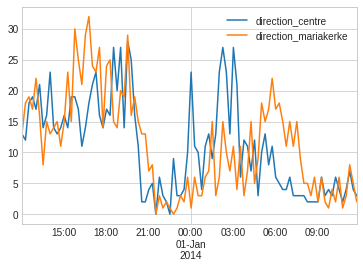

In [88]:
newyear.plot()

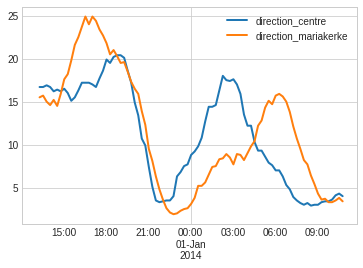

In [89]:
newyear.rolling(10, center=True).mean().plot(linewidth=2)

A more advanced usage of matplotlib to create a combined plot:

Text(0, 0.5, 'Cyclists count')

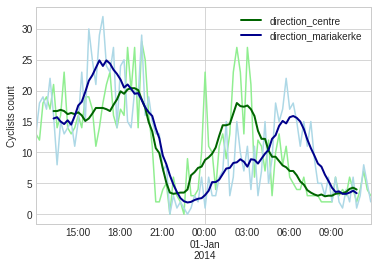

In [90]:
# A more in-detail plotting version of the graph.
fig, ax = plt.subplots()
newyear.plot(ax=ax, color=['LightGreen', 'LightBlue'], legend=False, rot=0)
newyear.rolling(10, center=True).mean().plot(linewidth=2, ax=ax, color=['DarkGreen', 'DarkBlue'], rot=0)

ax.set_xlabel('')
ax.set_ylabel('Cyclists count')

---

## The power of `groupby`...

Looking at the data in the above exercises, there seems to be clearly a:

- daily pattern
- weekly pattern
- yearly pattern

Such patterns can easily be calculated and visualized in pandas using the DatetimeIndex attributes `weekday` combined with `groupby` functionality. Below a taste of the possibilities, and we will learn about this in the proceeding notebooks:

**Weekly pattern**:

In [91]:
df_daily = df.resample('D').sum()

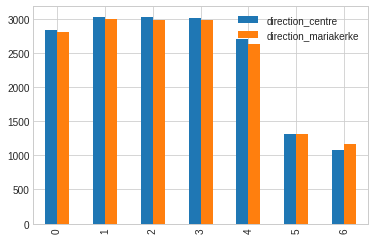

In [92]:
df_daily.groupby(df_daily.index.weekday).mean().plot(kind='bar')

**Daily pattern:**

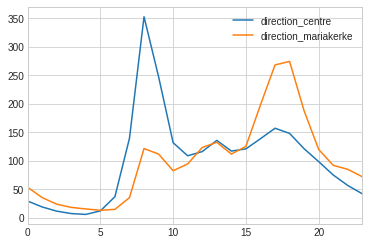

In [93]:
df_hourly.groupby(df_hourly.index.hour).mean().plot()

So the daily pattern is clearly different for both directions. In the morning more people go north, in the evening more people go south. The morning peak is also more condensed.

**Monthly pattern**

In [94]:
df_monthly = df.resample('M').sum()

In [95]:
from calendar import month_abbr 

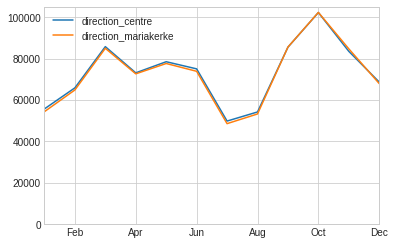

In [96]:
ax = df_monthly.groupby(df_monthly.index.month).mean().plot()
ax.set_ylim(0)
xlabels = ax.set_xticklabels(list(month_abbr)[0::2]) #too lazy to write the month values yourself...

## Acknowledgements
Thanks to the [city of Ghent](https://data.stad.gent/) for opening their data